In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
!git clone https://github.com/camenduru/Matting-Anything
%cd /content/Matting-Anything



/content
Cloning into 'Matting-Anything'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 131 (delta 15), reused 113 (delta 7), pack-reused 0
Receiving objects: 100% (131/131), 11.87 MiB | 27.88 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/Matting-Anything


In [ ]:
!pip install -r requirements.txt  #gradio쓰려면 gradio = 3.34.0으로 바꿔줘야함
!pip install -e segment-anything

%env BUILD_WITH_CUDA=True
!pip install -e GroundingDINO
!pip install --upgrade diffusers[torch]

!apt -y install -qq aria2
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Matting-Anything/resolve/main/mam_sam_vitb.pth -d /content/Matting-Anything/checkpoints -o mam_sam_vitb.pth
#!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Matting-Anything/resolve/main/mam_sam_vith.pth -d /content/Matting-Anything/checkpoints -o mam_sam_vith.pth #배포되어 있지 않음
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/Matting-Anything/resolve/main/groundingdino_swint_ogc.pth -d /content/Matting-Anything/checkpoints -o groundingdino_swint_ogc.pth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 8.2

In [ ]:
#%cd /content/Matting-Anything
#!python gradio_app.py --share

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
#gradio_app.py

# ------------------------------------------------------------------------
# Modified from Grounded-SAM (https://github.com/IDEA-Research/Grounded-Segment-Anything)
# ------------------------------------------------------------------------
import os
import random
import cv2
from scipy import ndimage

import gradio as gr
import argparse

import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import networks
import utils

# Grounding DINO
import sys
#sys.path.insert(0, './Grounded-Segment-Anything')  #이상한 경로.....
sys.path.insert(0, '/content/Matting-Anything/GroundingDINO')
from groundingdino.util.inference import Model

# SAM
sys.path.insert(0, './segment-anything')
from segment_anything.utils.transforms import ResizeLongestSide

# SD
from diffusers import StableDiffusionPipeline

transform = ResizeLongestSide(1024)
# Green Screen
PALETTE_back = (51, 255, 146)

GROUNDING_DINO_CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "checkpoints/groundingdino_swint_ogc.pth"
mam_checkpoint="checkpoints/mam_sam_vitb.pth" #이거 key에 맞는지 보기
output_dir="outputs"
device="cuda"
background_list = os.listdir('assets/backgrounds')

# initialize MAM
mam_model = networks.get_generator_m2m(seg='sam', m2m='sam_decoder_deep')
mam_model.to(device)
checkpoint = torch.load(mam_checkpoint, map_location=device)
mam_model.load_state_dict(utils.remove_prefix_state_dict(checkpoint['state_dict']), strict=True)
mam_model = mam_model.eval()

# initialize GroundingDINO
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH, device=device)

# initialize StableDiffusionPipeline
generator = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
generator.to(device)

def run_grounded_sam(input_image, text_prompt, task_type, background_prompt, background_type, box_threshold, text_threshold, iou_threshold, scribble_mode, guidance_mode):

    global groundingdino_model, sam_predictor, generator

    # make dir
    os.makedirs(output_dir, exist_ok=True)
     # load image
    #image_ori = input_image["image"]
    image_ori = input_image
    #scribble = input_image["mask"]   #scribble하려면 이부분 수정해야함

    original_size = image_ori.shape[:2]

    if task_type == 'text':
        if text_prompt is None:
            print('Please input non-empty text prompt')
        with torch.no_grad():
            detections, phrases = grounding_dino_model.predict_with_caption(
                image=cv2.cvtColor(image_ori, cv2.COLOR_RGB2BGR),
                caption=text_prompt,
                box_threshold=box_threshold,
                text_threshold=text_threshold
            )

        if len(detections.xyxy) > 1:
            nms_idx = torchvision.ops.nms(
                torch.from_numpy(detections.xyxy),
                torch.from_numpy(detections.confidence),
                iou_threshold,
            ).numpy().tolist()

            detections.xyxy = detections.xyxy[nms_idx]
            detections.confidence = detections.confidence[nms_idx]

        bbox = detections.xyxy[np.argmax(detections.confidence)]
        bbox = transform.apply_boxes(bbox, original_size)
        bbox = torch.as_tensor(bbox, dtype=torch.float).to(device)
        print('bbox',bbox)

    image = transform.apply_image(image_ori)
    image = torch.as_tensor(image).to(device)
    image = image.permute(2, 0, 1).contiguous()

    pixel_mean = torch.tensor([123.675, 116.28, 103.53]).view(3,1,1).to(device)
    pixel_std = torch.tensor([58.395, 57.12, 57.375]).view(3,1,1).to(device)

    image = (image - pixel_mean) / pixel_std

    h, w = image.shape[-2:]
    pad_size = image.shape[-2:]
    padh = 1024 - h
    padw = 1024 - w
    image = F.pad(image, (0, padw, 0, padh))

    if task_type == 'scribble_point':
        scribble = scribble.transpose(2, 1, 0)[0]

        labeled_array, num_features = ndimage.label(scribble >= 255)

        centers = ndimage.center_of_mass(scribble, labeled_array, range(1, num_features+1))
        centers = np.array(centers)
        ### (x,y)
        centers = transform.apply_coords(centers, original_size)
        point_coords = torch.from_numpy(centers).to(device)
        point_coords = point_coords.unsqueeze(0).to(device)
        point_labels = torch.from_numpy(np.array([1] * len(centers))).unsqueeze(0).to(device)
        if scribble_mode == 'split':
            point_coords = point_coords.permute(1, 0, 2)
            point_labels = point_labels.permute(1, 0)

        sample = {'image': image.unsqueeze(0), 'point': point_coords, 'label': point_labels, 'ori_shape': original_size, 'pad_shape': pad_size}
    elif task_type == 'scribble_box':
        scribble = scribble.transpose(2, 1, 0)[0]
        labeled_array, num_features = ndimage.label(scribble >= 255)
        centers = ndimage.center_of_mass(scribble, labeled_array, range(1, num_features+1))
        centers = np.array(centers)
        ### (x1, y1, x2, y2)
        x_min = centers[:, 0].min()
        x_max = centers[:, 0].max()
        y_min = centers[:, 1].min()
        y_max = centers[:, 1].max()
        bbox = np.array([x_min, y_min, x_max, y_max])
        bbox = transform.apply_boxes(bbox, original_size)
        bbox = torch.as_tensor(bbox, dtype=torch.float).to(device)

        sample = {'image': image.unsqueeze(0), 'bbox': bbox.unsqueeze(0), 'ori_shape': original_size, 'pad_shape': pad_size}
    elif task_type == 'text':
        sample = {'image': image.unsqueeze(0), 'bbox': bbox.unsqueeze(0), 'ori_shape': original_size, 'pad_shape': pad_size}
    else:
        print("task_type:{} error!".format(task_type))

    with torch.no_grad():
        print("before sam, mam")
        #imshow(image) -> MAM 전, 즉 sam, mam 전 이미지 볼 수 있음
        numpy_image = image.cpu().detach().numpy()
        numpy_image = np.transpose(numpy_image, (1, 2, 0))
        plt.imshow(numpy_image)
        plt.axis('off')  # Turn off axis labels and ticks
        plt.show()

        #apply sam, mam
        feas, pred, post_mask = mam_model.forward_inference(sample)
        post_mask_fi = post_mask

        print("post_mask after sam, mam")
        #imshow(image) -> MAM 전, 즉 sam, mam 전 이미지 볼 수 있음
        post_mask1 = post_mask.cpu().detach().numpy()  # If using GPU, move tensor to CPU before conversion

        # If the tensor has a single channel (grayscale image)
        if post_mask1.shape[0] == 1:
            # Reshape (1, H, W) to (H, W)
            post_mask1 = post_mask1.squeeze(0)
            post_mask1 = np.transpose(post_mask1, (1, 2, 0))

        # If the tensor has three channels (RGB image)
        if post_mask1.shape[0] == 3:
            # Reshape (3, H, W) to (H, W, 3)
            post_mask1 = np.transpose(post_mask1, (1, 2, 0))

        # Display the image using Matplotlib
        plt.imshow(post_mask1*256)
        plt.axis('off')  # Turn off axis labels and ticks
        plt.show()



        alpha_pred_os1, alpha_pred_os4, alpha_pred_os8 = pred['alpha_os1'], pred['alpha_os4'], pred['alpha_os8']
        alpha_pred_os8 = alpha_pred_os8[..., : sample['pad_shape'][0], : sample['pad_shape'][1]]
        alpha_pred_os4 = alpha_pred_os4[..., : sample['pad_shape'][0], : sample['pad_shape'][1]]
        alpha_pred_os1 = alpha_pred_os1[..., : sample['pad_shape'][0], : sample['pad_shape'][1]]

        alpha_pred_os8 = F.interpolate(alpha_pred_os8, sample['ori_shape'], mode="bilinear", align_corners=False)
        alpha_pred_os4 = F.interpolate(alpha_pred_os4, sample['ori_shape'], mode="bilinear", align_corners=False)
        alpha_pred_os1 = F.interpolate(alpha_pred_os1, sample['ori_shape'], mode="bilinear", align_corners=False)

        if guidance_mode == 'mask':
            weight_os8 = utils.get_unknown_tensor_from_mask_oneside(post_mask, rand_width=10, train_mode=False)
            post_mask[weight_os8>0] = alpha_pred_os8[weight_os8>0]
            alpha_pred = post_mask.clone().detach()
        else:
            weight_os8 = utils.get_unknown_box_from_mask(post_mask)
            alpha_pred_os8[weight_os8>0] = post_mask[weight_os8>0]
            alpha_pred = alpha_pred_os8.clone().detach()


        weight_os4 = utils.get_unknown_tensor_from_pred_oneside(alpha_pred, rand_width=20, train_mode=False)
        alpha_pred[weight_os4>0] = alpha_pred_os4[weight_os4>0]

        weight_os1 = utils.get_unknown_tensor_from_pred_oneside(alpha_pred, rand_width=10, train_mode=False)
        alpha_pred[weight_os1>0] = alpha_pred_os1[weight_os1>0]
        alpha_pred_print = alpha_pred
        alpha_pred = alpha_pred[0][0].cpu().numpy()

    #### draw
    ### alpha matte
    alpha_rgb = cv2.cvtColor(np.uint8(alpha_pred*255), cv2.COLOR_GRAY2RGB)
    ### com img with background
    if background_type == 'real_world_sample':
        background_img_file = os.path.join('assets/backgrounds', random.choice(background_list))
        background_img = cv2.imread(background_img_file)
        background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
        background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
        com_img = alpha_pred[..., None] * image_ori + (1 - alpha_pred[..., None]) * np.uint8(background_img)
        com_img = np.uint8(com_img)
    else:
        if background_prompt is None:
            print('Please input non-empty background prompt')
        else:
            background_img = generator(background_prompt).images[0]
            background_img = np.array(background_img)
            background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
            com_img = alpha_pred[..., None] * image_ori + (1 - alpha_pred[..., None]) * np.uint8(background_img)
            com_img = np.uint8(com_img)
    ### com img with green screen
    green_img = alpha_pred[..., None] * image_ori + (1 - alpha_pred[..., None]) * np.array([PALETTE_back], dtype='uint8')
    green_img = np.uint8(green_img)



        #### scale 단계별로 그리기 : draw


      #scale 8:
    feas, pred, post_mask = mam_model.forward_inference(sample) #깨끗한 post_mask 준비
    post_mask[weight_os8>0] = alpha_pred_os8[weight_os8>0]
    alpha_pred_8 = post_mask.clone().detach()

    alpha_pred_8 = alpha_pred_8[0][0].cpu().numpy()
    ### alpha matte
    alpha_rgb_8 = cv2.cvtColor(np.uint8(alpha_pred_8*255), cv2.COLOR_GRAY2RGB)
    ### com img with background
    if background_type == 'real_world_sample':
        background_img_file = os.path.join('assets/backgrounds', random.choice(background_list))
        background_img = cv2.imread(background_img_file)
        background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
        background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
        com_img_8 = alpha_pred_8[..., None] * image_ori + (1 - alpha_pred_8[..., None]) * np.uint8(background_img)
        com_img_8 = np.uint8(com_img_8)
    else:
        if background_prompt is None:
            print('Please input non-empty background prompt')
        else:
            background_img = generator(background_prompt).images[0]
            background_img = np.array(background_img)
            background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
            com_img_8 = alpha_pred_8[..., None] * image_ori + (1 - alpha_pred_8[..., None]) * np.uint8(background_img)
            com_img_8 = np.uint8(com_img_8)
    ### com img with green screen
    green_img_8 = alpha_pred_8[..., None] * image_ori + (1 - alpha_pred_8[..., None]) * np.array([PALETTE_back], dtype='uint8')
    green_img_8 = np.uint8(green_img_8)


          #scale 4:
    feas, pred, post_mask = mam_model.forward_inference(sample) #깨끗한 post_mask 준비
    post_mask[weight_os4>0] = alpha_pred_os4[weight_os4>0]
    alpha_pred_4 = post_mask.clone().detach()

    alpha_pred_4 = alpha_pred_4[0][0].cpu().numpy()
    ### alpha matte
    alpha_rgb_4 = cv2.cvtColor(np.uint8(alpha_pred_4*255), cv2.COLOR_GRAY2RGB)
    ### com img with background
    if background_type == 'real_world_sample':
        background_img_file = os.path.join('assets/backgrounds', random.choice(background_list))
        background_img = cv2.imread(background_img_file)
        background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
        background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
        com_img_4 = alpha_pred_4[..., None] * image_ori + (1 - alpha_pred_4[..., None]) * np.uint8(background_img)
        com_img_4 = np.uint8(com_img_4)
    else:
        if background_prompt is None:
            print('Please input non-empty background prompt')
        else:
            background_img = generator(background_prompt).images[0]
            background_img = np.array(background_img)
            background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
            com_img_4 = alpha_pred_4[..., None] * image_ori + (1 - alpha_pred_4[..., None]) * np.uint8(background_img)
            com_img_4 = np.uint8(com_img_4)
    ### com img with green screen
    green_img_4 = alpha_pred_4[..., None] * image_ori + (1 - alpha_pred_4[..., None]) * np.array([PALETTE_back], dtype='uint8')
    green_img_4 = np.uint8(green_img_4)


              #scale 1:
    feas, pred, post_mask = mam_model.forward_inference(sample) #깨끗한 post_mask 준비
    post_mask[weight_os1>0] = alpha_pred_os1[weight_os1>0]
    alpha_pred_1 = post_mask.clone().detach()

    alpha_pred_1 = alpha_pred_1[0][0].cpu().numpy()
    ### alpha matte
    alpha_rgb_1 = cv2.cvtColor(np.uint8(alpha_pred_1*255), cv2.COLOR_GRAY2RGB)
    ### com img with background
    if background_type == 'real_world_sample':
        background_img_file = os.path.join('assets/backgrounds', random.choice(background_list))
        background_img = cv2.imread(background_img_file)
        background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
        background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
        com_img_1 = alpha_pred_1[..., None] * image_ori + (1 - alpha_pred_1[..., None]) * np.uint8(background_img)
        com_img_1 = np.uint8(com_img_1)
    else:
        if background_prompt is None:
            print('Please input non-empty background prompt')
        else:
            background_img = generator(background_prompt).images[0]
            background_img = np.array(background_img)
            background_img = cv2.resize(background_img, (image_ori.shape[1], image_ori.shape[0]))
            com_img_1 = alpha_pred_1[..., None] * image_ori + (1 - alpha_pred_1[..., None]) * np.uint8(background_img)
            com_img_1 = np.uint8(com_img_1)
    ### com img with green screen
    green_img_1 = alpha_pred_1[..., None] * image_ori + (1 - alpha_pred_1[..., None]) * np.array([PALETTE_back], dtype='uint8')
    green_img_1 = np.uint8(green_img_1)





    return [(com_img, 'composite with background'), (green_img, 'green screen'), (alpha_rgb, 'alpha matte'),(com_img_8, 'composite with background'), (green_img_8, 'green screen'), (alpha_rgb_8, 'alpha matte'),(com_img_4, 'composite with background'), (green_img_4, 'green screen'), (alpha_rgb_4, 'alpha matte'),(com_img_1, 'composite with background'), (green_img_1, 'green screen'), (alpha_rgb_1, 'alpha matte') ,feas, pred, post_mask,weight_os8,weight_os4,weight_os1, post_mask1,alpha_pred_print ]

'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser("MAM demo", add_help=True)
    parser.add_argument("--debug", action="store_true", help="using debug mode")
    parser.add_argument("--share", action="store_true", help="share the app")
    parser.add_argument('--port', type=int, default=7589, help='port to run the server')
    parser.add_argument('--no-gradio-queue', action="store_true", help='path to the SAM checkpoint')
    args = parser.parse_args()

    print(args)

    block = gr.Blocks()
    if not args.no_gradio_queue:
        block = block.queue()

    with block:
        gr.Markdown(
        """
        # MAM Demo
        Welcome to the MAM demo and upload your image to get started <br/> You may select different prompt types to get the alpha matte of target instance, and select different backgrounds for image composition.
        ## Usage
        You may check the <a href='https://www.youtube.com/watch?v=U0Bbst3LzIE'>video</a> to see how to play with the demo, or check the details below.
        <details>
        You may upload an image to start, we support 3 prompt types to get the alpha matte of the target instance：

        **scribble_point**: Click an point on the target instance.

        **scribble_box**: Click on two points, the top-left point and the bottom-right point to represent a bounding box of the target instance.

        **text**: Send text prompt to identify the target instance in the `Text prompt` box.

        We also support 2 background types to support image composition with the alpha matte output:

        **real_world_sample**: Randomly select a real-world image from `assets/backgrounds` for composition.

        **generated_by_text**: Send background text prompt to create a background image with stable diffusion model in the `Background prompt` box.
        </details>
        """)

        with gr.Row():
            with gr.Column():
                input_image = gr.Image(source='upload', type="numpy", value="assets/demo.jpg", tool="sketch")
                task_type = gr.Dropdown(["scribble_point", "scribble_box", "text"], value="text", label="Prompt type")
                text_prompt = gr.Textbox(label="Text prompt", placeholder="the girl in the middle")
                background_type = gr.Dropdown(["generated_by_text", "real_world_sample"], value="generated_by_text", label="Background type")
                background_prompt = gr.Textbox(label="Background prompt", placeholder="downtown area in New York")
                run_button = gr.Button(label="Run")
                with gr.Accordion("Advanced options", open=False):
                    box_threshold = gr.Slider(
                        label="Box Threshold", minimum=0.0, maximum=1.0, value=0.25, step=0.05
                    )
                    text_threshold = gr.Slider(
                        label="Text Threshold", minimum=0.0, maximum=1.0, value=0.25, step=0.05
                    )
                    iou_threshold = gr.Slider(
                        label="IOU Threshold", minimum=0.0, maximum=1.0, value=0.5, step=0.05
                    )
                    scribble_mode = gr.Dropdown(
                        ["merge", "split"], value="split", label="scribble_mode"
                    )
                    guidance_mode = gr.Dropdown(
                        ["mask", "alpha"], value="alpha", label="guidance_mode", info="mask guidance is for complex scenes with multiple instances, alpha guidance is for simple scene with single instance"
                    )

            with gr.Column():
                gallery = gr.Gallery(
                    label="Generated images", show_label=True, elem_id="gallery"
                ).style(preview=True, grid=3, object_fit="scale-down")

        run_button.click(fn=run_grounded_sam, inputs=[
                        input_image, text_prompt, task_type, background_prompt, background_type, box_threshold, text_threshold, iou_threshold, scribble_mode, guidance_mode], outputs=gallery)

    block.queue(concurrency_count=100)
    block.launch(server_name='0.0.0.0', server_port=args.port, debug=args.debug, share=args.share)
'''


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


'\nif __name__ == "__main__":\n    parser = argparse.ArgumentParser("MAM demo", add_help=True)\n    parser.add_argument("--debug", action="store_true", help="using debug mode")\n    parser.add_argument("--share", action="store_true", help="share the app")\n    parser.add_argument(\'--port\', type=int, default=7589, help=\'port to run the server\')\n    parser.add_argument(\'--no-gradio-queue\', action="store_true", help=\'path to the SAM checkpoint\')\n    args = parser.parse_args()\n\n    print(args)\n\n    block = gr.Blocks()\n    if not args.no_gradio_queue:\n        block = block.queue()\n\n    with block:\n        gr.Markdown(\n        """\n        # MAM Demo\n        Welcome to the MAM demo and upload your image to get started <br/> You may select different prompt types to get the alpha matte of target instance, and select different backgrounds for image composition.\n        ## Usage\n        You may check the <a href=\'https://www.youtube.com/watch?v=U0Bbst3LzIE\'>video</a> to 

In [ ]:
import cv2

#input_image = cv2.imread('/content/동물원에 갇힌 원숭이.png', cv2.IMREAD_COLOR)
input_url="/content/동물원에 갇힌 원숭이 (1) (1) (1).png"
input_image = cv2.imread(input_url)
text_prompt = "a monkey in the middle"
task_type = "text"
background_prompt= ""
background_type= "real_world_sample"
box_threshold = 0.25
text_threshold = 0.25
iou_threshold=0.5
scribble_mode= "split"
guidance_mode="alpha"

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


bbox tensor([[ 1.9663e-01, -9.1911e-02,  7.6146e+02,  5.8287e+02]], device='cuda:0')
before sam, mam


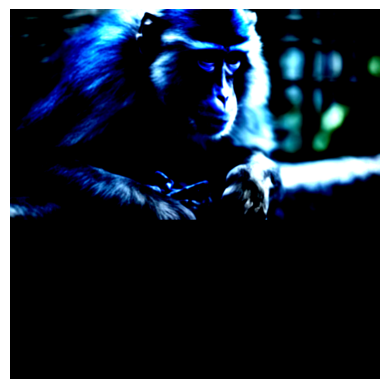

post_mask after sam, mam


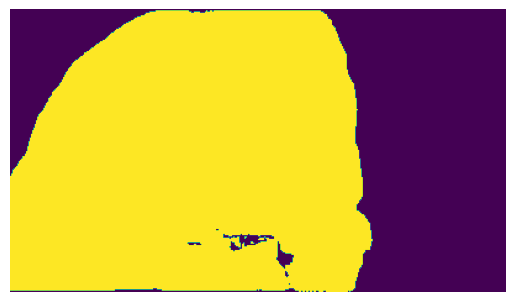

In [ ]:
output=run_grounded_sam(input_image, text_prompt, task_type, background_prompt, background_type, box_threshold, text_threshold, iou_threshold, scribble_mode, guidance_mode)

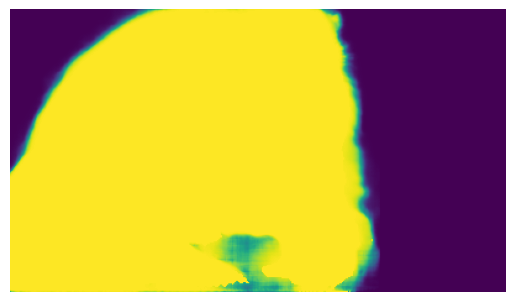

In [ ]:
plt.imshow(np.array(output[19][0][0].cpu())*255*255*255)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [ ]:
#(1024,1024,3) black and white mask to (1024,1024) 0 and 1 mask

#gray_image = cv2.cvtColor(output[2][0]*255, cv2.COLOR_BGR2GRAY)
#gray_image = cv2.cvtColor(output[18]*255, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to get a binary image
ret, threshold_image = cv2.threshold(output[18]*255, 127, 255, cv2.THRESH_BINARY)

# Display or use the thresholded image (1024x1024)
# threshold_image contains values of 0 for black and 255 for white

# If you need the values in a NumPy array, you can simply do:
new_array = threshold_image

In [ ]:
#matting anything 처음 output 결과 이미지로 저장하기

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the original image
#original_image = cv2.imread('path_to_original_image.jpg')  # Replace 'path_to_original_image.jpg' with your image path = input_image

# Assuming you have the 'foreground' result from the previous step
# foreground is the image with the labeled foreground regions filled with white
# Ensure the 'foreground' and 'original_image' have the same dimensions

# Convert foreground to grayscale
#colored_mask_gray = cv2.cvtColor(new_array, cv2.COLOR_BGR2GRAY) #output[2][0]: alpha mask

# Create an alpha channel from the foreground image (0 for background, 255 for foreground)
alpha = np.zeros_like(new_array)
alpha[new_array == 255.] = 255  # Set alpha to 255 where foreground is present

# Merge the original image with the alpha channel
rgba_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2BGRA)

# Assign the alpha channel to the fourth channel of the RGBA image
rgba_image[:, :, 3] = alpha


#save
file_name = '/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_matting_anything/' + text_prompt + '.png'

# Save the resulting image with alpha channel as PNG
cv2.imwrite(file_name, rgba_image)


True

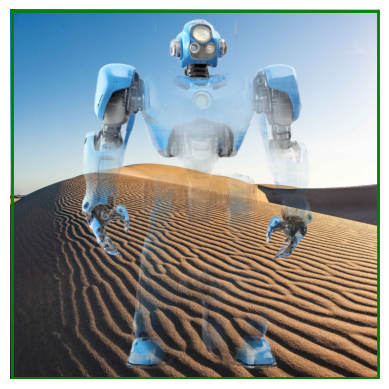

In [ ]:
#[(com_img, 'composite with background'), (green_img, 'green screen'), (alpha_rgb, 'alpha matte')]
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.imshow(output[0][0])
plt.axis('off')  # Turn off axis labels and ticks
#plt.show()

x_min=4.5041
y_min=2.8957
x_max=1019.8051
y_max=1019.9006

# Create a rectangle patch
rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')

# Add the rectangle to the plot
plt.gca().add_patch(rectangle)

# Show the image with bounding box
plt.show()


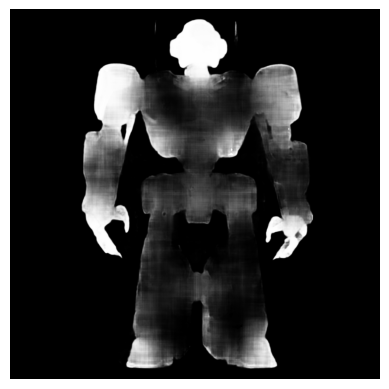

In [ ]:
#[(com_img, 'composite with background'), (green_img, 'green screen'), (alpha_rgb, 'alpha matte')]
import matplotlib.pyplot as plt
plt.imshow(output[2][0])
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


## Scale 별로 print

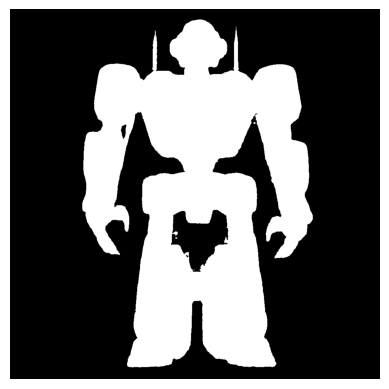

In [ ]:
#alphamatte-os8
import matplotlib.pyplot as plt
plt.imshow(output[5][0])
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

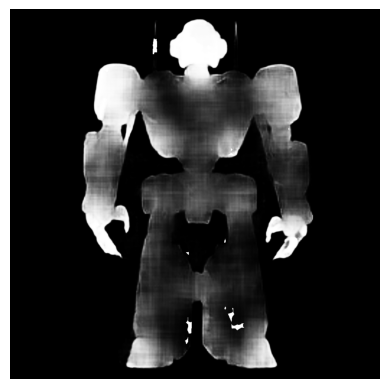

In [ ]:
#alphamatte-os4
import matplotlib.pyplot as plt
plt.imshow(output[8][0])
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

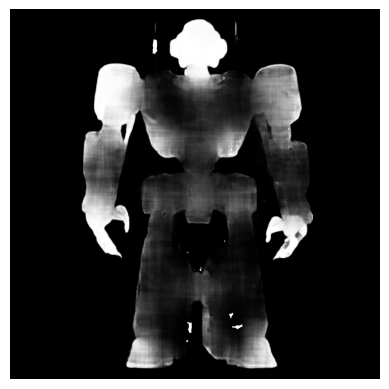

In [ ]:
#alphamatte-os1
import matplotlib.pyplot as plt
plt.imshow(output[11][0])
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

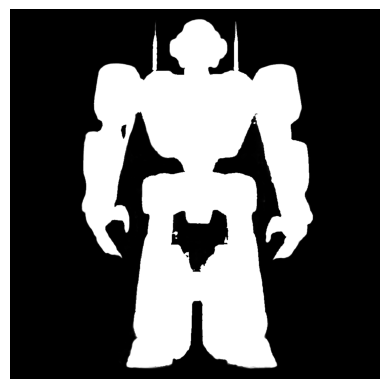

In [ ]:
#alphamatte-os8 + os1
import matplotlib.pyplot as plt
plt.imshow(np.maximum(output[5][0], output[11][0]))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# color inside max(os1,os8)

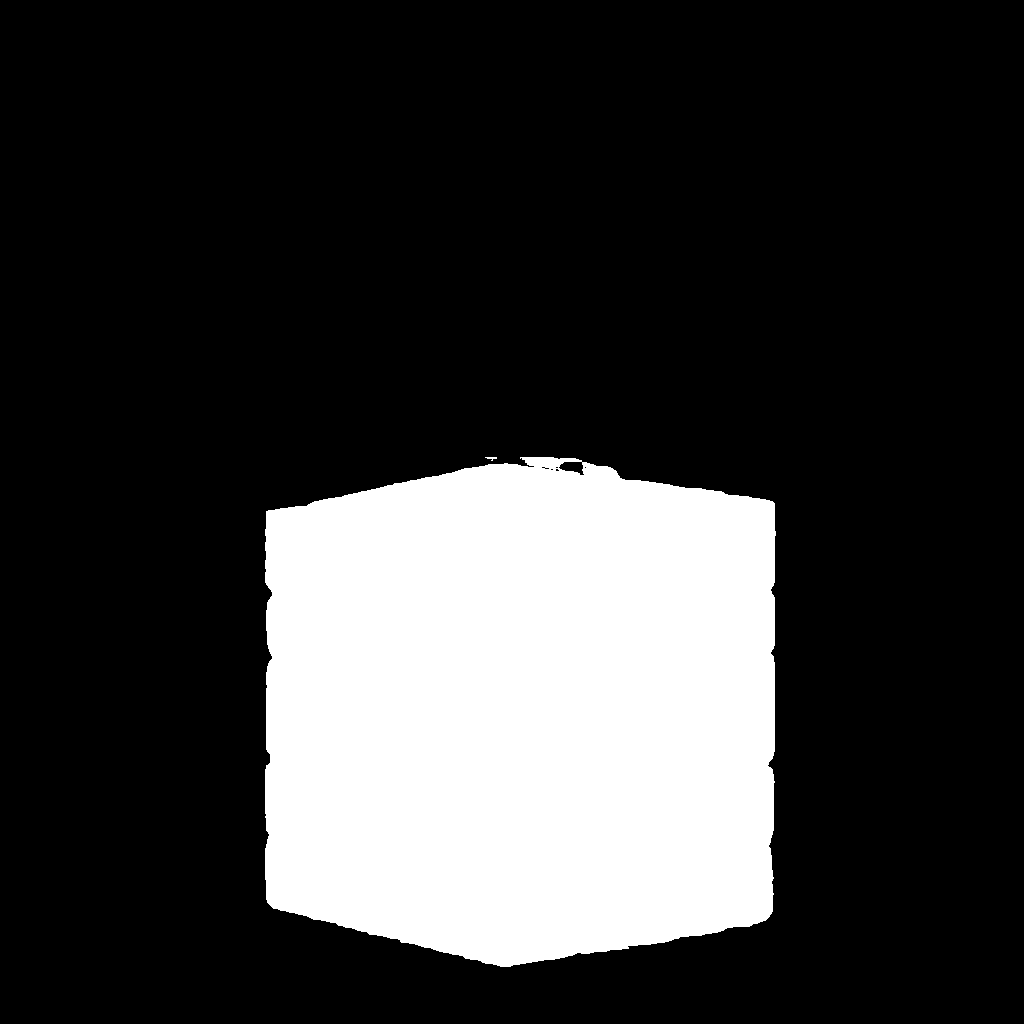

In [ ]:
#색칠


import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 이미지 읽기 (Assuming output[5][0] and output[11][0] are images with dimensions (1024, 1024, 3))
img = np.maximum(output[5][0], output[11][0])

# 그레이 스케일로 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 이진화하여 전경과 배경 분리
_, th = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 연결된 요소 레이블링 적용
cnt, labels = cv2.connectedComponents(th)

# 전경 영역 채우기
colored_mask = np.zeros_like(img)
colored_mask[labels > 0] = 255  # Assign white color to labeled regions

# 결과 출력
cv2_imshow(colored_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
colored_mask_gray = cv2.cvtColor(colored_mask, cv2.COLOR_BGR2GRAY)

# Create an alpha channel from the foreground image (0 for background, 255 for foreground)
alpha = np.zeros_like(colored_mask_gray)
alpha[colored_mask_gray == 255] = 255

In [ ]:
colored_mask_gray==255

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the original image
#original_image = cv2.imread('path_to_original_image.jpg')  # Replace 'path_to_original_image.jpg' with your image path = input_image

# Assuming you have the 'foreground' result from the previous step
# foreground is the image with the labeled foreground regions filled with white
# Ensure the 'foreground' and 'original_image' have the same dimensions

# Convert foreground to grayscale
colored_mask_gray = cv2.cvtColor(colored_mask, cv2.COLOR_BGR2GRAY)

# Create an alpha channel from the foreground image (0 for background, 255 for foreground)
alpha = np.zeros_like(colored_mask_gray)
alpha[colored_mask_gray == 255] = 255  # Set alpha to 255 where foreground is present

# Merge the original image with the alpha channel
result = cv2.merge((input_image, alpha))

#save
file_name = '/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_matting_anything_color/' + text_prompt + '.png'

# Save the resulting image with alpha channel as PNG
cv2.imwrite(file_name, result)


True